In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [3]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

# Basics
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators.simulator import simulator
import ssms
from pptx import Presentation
from pptx.util import Inches
# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

import jax
jax.config.update("jax_enable_x64", False)

import src.utils.setup_figures as figures
import src.utils.basic as utils


jax.devices()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[CudaDevice(id=0), CudaDevice(id=1)]

# Config

In [4]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

data = pd.read_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index_col=None)

# exclude the following subjects where categorization score is more than 2
reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 2]['subject_id']
processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]
processed_data = data.loc[~data["subject"].isin(reject_subs)]


# Utils

In [85]:
def get_simulated_data(model_name, model):
    model.find_MAP()
    params = {}
    for param in list(model.list_params):
        if param != "p_outlier":
            params[param] = model.map[param]

    simulated_data = hssm.simulate_data(model=model_name, theta=params, size=1)
    return simulated_data

def plot_ppt(model_idata):
    prs = Presentation()
    slide_layout = prs.slide_layouts[5]
    
    for subject in model_idata.keys():
        fig = az.plot_trace(model_idata[subject], combined=True, compact=True)
        plt.savefig("model_trace.png")
        plt.close()
        slide = prs.slides.add_slide(slide_layout)
        title = slide.shapes.title
        title.text = f"Subject: {subject}"
        slide = prs.slides.add_slide(slide_layout)
        slide.shapes.add_picture("model_trace.png", left=Inches(0.01), top=Inches(0.01), width=Inches(8))
    
    Path("model_trace.png").unlink()
    return prs


## Model

In [5]:
processed_data.head()                                           

,subject,medication,prior,prior_direction,prior_color,color,coherence,target,is_valid,outcome,choice,reaction_time,session_name,signed_coherence
0,CG,off,rl,left,red,1,100.0,1,True,True,1,626.976669,Brady_CG_OFFmeds_rl.mat,100.0
1,CG,off,rl,left,red,-1,0.0,1,True,False,-1,945.801775,Brady_CG_OFFmeds_rl.mat,0.0
2,CG,off,rl,left,red,-1,0.0,-1,True,False,1,964.249405,Brady_CG_OFFmeds_rl.mat,-0.0
3,CG,off,rl,left,red,-1,100.0,-1,True,True,-1,671.215080,Brady_CG_OFFmeds_rl.mat,-100.0
4,CG,off,rl,left,red,-1,0.0,1,True,True,1,1046.959465,Brady_CG_OFFmeds_rl.mat,0.0


### Loading Dataset

processed_data  
&ensp;&ensp;color: &ensp;&ensp;&ensp;&ensp;&ensp;{prior: 1, equal: -1}  
&ensp;&ensp;direction: &ensp;&ensp;{prior: 1, equal: -1}

In [6]:
data = pd.DataFrame(
    {
        "rt": processed_data["reaction_time"]/1000,
        "response": processed_data["choice"],
        "stimulus": processed_data["signed_coherence"]/100,
        "color": processed_data["color"].astype("category"),
        "treatment": processed_data["medication"].replace({"off": 0, "on": 1}).astype("category"),
        "subject": processed_data["subject"],
    }
)

In [82]:
def get_weibull_model(data):
    weibull_model = hssm.HSSM(
        data = data,
        model = "weibull",
        include = [
            {
                "name": "v",
                # "formula": "v ~ (stimulus|C(treatment)*C(color))",
                "formula": "v ~ (stimulus|C(treatment))", #(stimulus|C(color)) + C(treatment)",
            },
            {
                "name": "z",
                "formula": "z ~ C(treatment)",# + (1|color)",
            },
        ],
        # p_outlier=0.4,
        # lapse=bmb.Prior("Uniform", lower=0.0, upper=40.0)
    )
    return weibull_model

get_weibull_model(data).initvals

Model initialized successfully.


{'t': array(0.025, dtype=float32),
 'beta': array(3.6499999, dtype=float32),
 'a': array(1.5, dtype=float32),
 'alpha': array(2.6499999, dtype=float32),
 'v_Intercept': array(0., dtype=float32),
 'v_1|C(treatment)_sigma': array(0.2708236, dtype=float32),
 'v_1|C(treatment)_offset': array([0.00419473, 0.00463719], dtype=float32),
 'v_stimulus|C(treatment)_mu': array(0., dtype=float32),
 'v_stimulus|C(treatment)_sigma': array(0.2708236, dtype=float32),
 'v_stimulus|C(treatment)_offset': array([ 0.00983497, -0.00020038], dtype=float32),
 'z_Intercept': array(0.5, dtype=float32),
 'z_C(treatment)': array([0.], dtype=float32)}

  0%|          | 0/1 [00:00<?, ?it/s]

Model initialized successfully.
Using default initvals. 



  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1/1 [00:30<00:00, 30.26s/it]


Subject: CG


array([[<Axes: title={'center': 'v_1|C(treatment)_sigma'}>,
        <Axes: title={'center': 'v_1|C(treatment)_sigma'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_1|C(treatment)'}>,
        <Axes: title={'center': 'v_1|C(treatment)'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment)_mu'}>,
        <Axes: title={'center': 'v_stimulus|C(treatment)_mu'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment)'}>,
        <Axes: title={'center': 'v_stimulus|C(treatment)'}>],
       [<Axes: title={'center': 'v_1|C(treatment)_offset'}>,
        <Axes: title={'center': 'v_1|C(treatment)_offset'}>],
       [<Axes: title={'center': 'z_Intercept'}>,
        <Axes: title={'center': 'z_Intercept'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'a'}>, <A

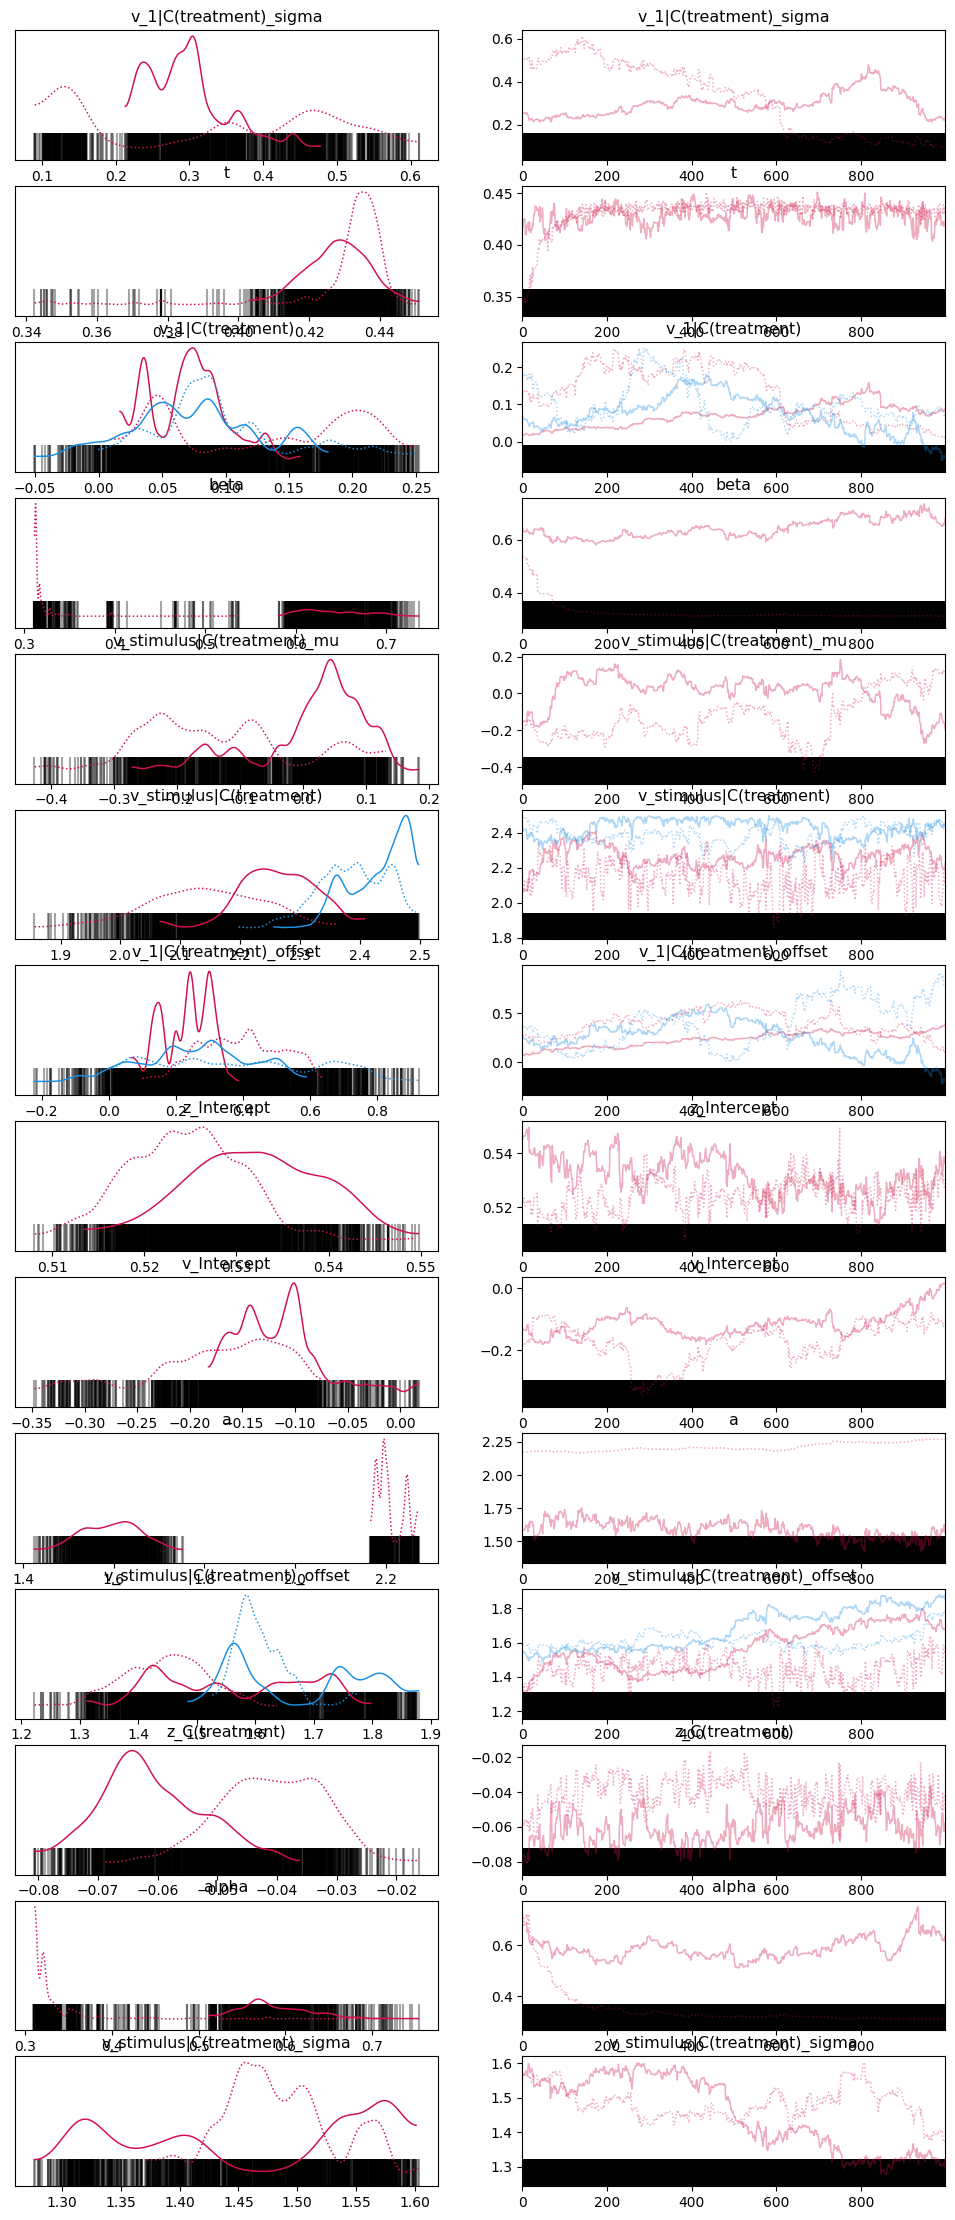

In [83]:
subjects = ['CG']#sorted(set(processed_metadata["subject_id"].values))
weibull_models_40lapse = {}
weibull_idata_40lapse = {}

divergences = 0
for i, subject in enumerate(tqdm(subjects)):
    temp_data=data.loc[data["subject"] == subject]
    weibull_models_40lapse[subject] = get_weibull_model(temp_data)
    weibull_idata_40lapse[subject] = weibull_models_40lapse[subject].sample(sampler="nuts_numpyro", chains=2, cores=2, draws=1000, tune=500)
    print(f"Subject: {subject}")
    
    # if weibull_idata_40lapse[subject].sample_stats.diverging.sum().values > 900:
    #     divergences += 1
    
    # if divergences > 5:
    #     break

az.plot_trace(weibull_idata_40lapse['CG'])

idx: 0, color: 1, treatment: 0
idx: 1, color: -1, treatment: 0
idx: 2, color: 1, treatment: 1
idx: 3, color: -1, treatment: 1


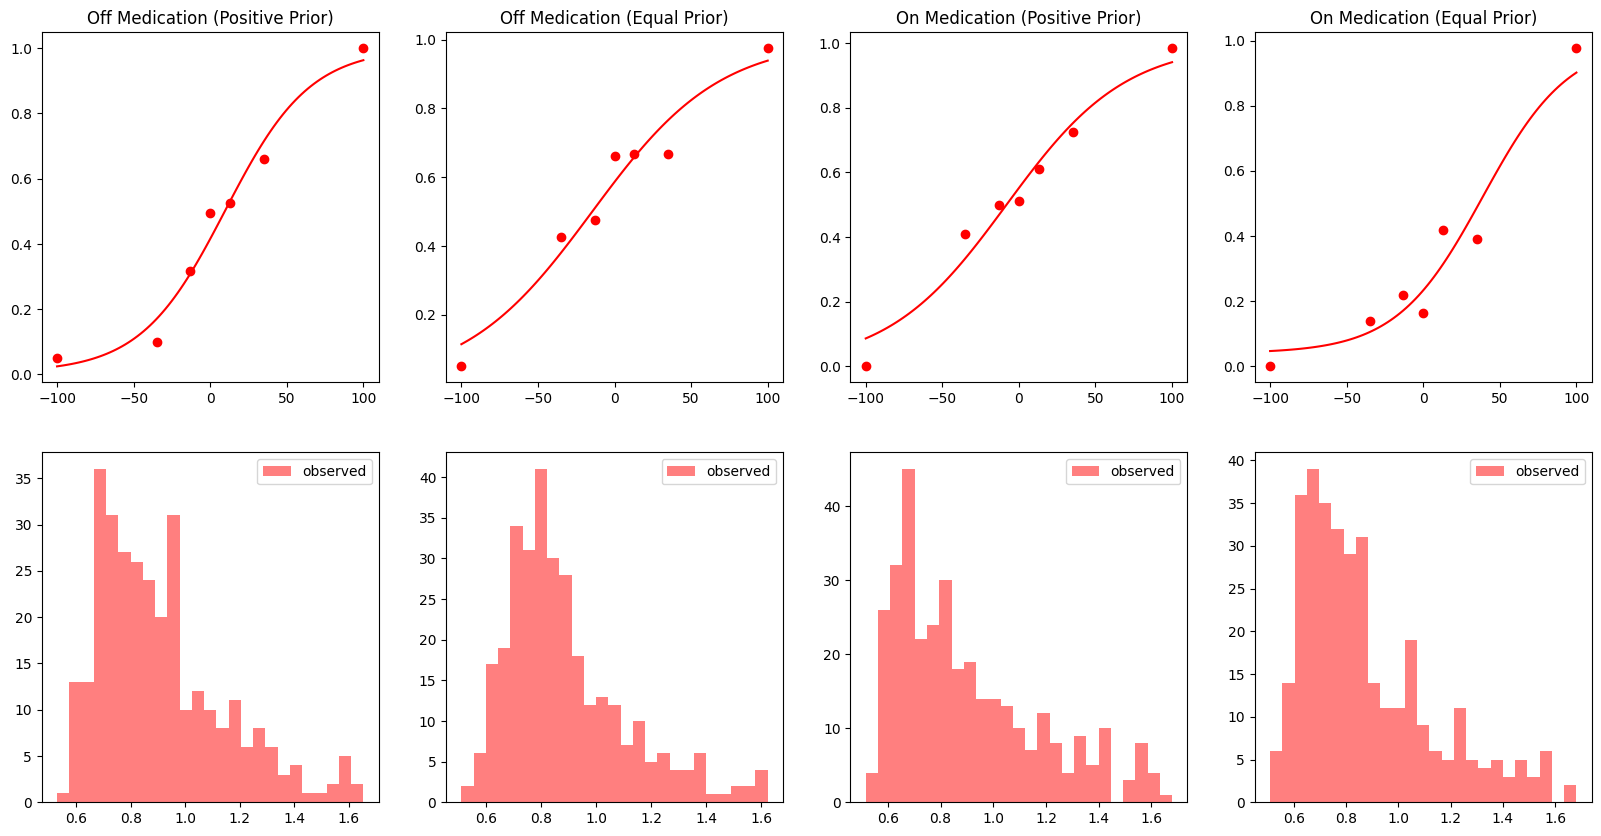

In [ ]:
observed_data = temp_data.copy()
observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100

simulated_data = get_simulated_data(model_name='weibull', model=weibull_models_40lapse)
simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
simulated_data.rename(columns={'response': 'choice'}, inplace=True)
simulated_data['color'] = observed_data['color'].values
simulated_data['treatment'] = observed_data['treatment'].values
simulated_data['subject'] = observed_data['subject'].values
treatments = observed_data['treatment'].unique()
colors = observed_data['color'].unique()
colors_treatments = [(treatment, color) for treatment in treatments for color in colors]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for idx, (treatment, color) in enumerate(colors_treatments):
        print(f"idx: {idx}, color: {color}, treatment: {treatment}")
        
        subset_idx = np.where((observed_data['treatment'] == treatment) & (observed_data['color'] == color))[0]
        # plot psychometric function
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(observed_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='red')
        ax[0, idx].plot(x_hat, y_hat, color='red')    
        if idx == 0:
                ax[0, idx].set_title(f"Off Medication (Positive Prior)")
        elif idx == 1:
                ax[0, idx].set_title(f"Off Medication (Equal Prior)")   
        elif idx == 2:
                ax[0, idx].set_title(f"On Medication (Positive Prior)")
        else:
                ax[0, idx].set_title(f"On Medication (Equal Prior)")
                
        ax[1, idx].hist(observed_data['rt'].iloc[subset_idx], bins=25, alpha=0.5, label='observed' , color='red')
        ax[1, idx].legend()

array([[<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment):C(color)_mu'}>,
        <Axes: title={'center': 'v_stimulus|C(treatment):C(color)_mu'}>],
       [<Axes: title={'center': 'z_C(color)'}>,
        <Axes: title={'center': 'z_C(color)'}>],
       [<Axes: title={'center': 'v_stimulus|C(color)_sigma'}>,
        <Axes: title={'center': 'v_stimulus|C(color)_sigma'}>],
       [<Axes: title={'center': 'v_stimulus|C(color)'}>,
        <Axes: title={'center': 'v_stimulus|C(color)'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment):C(color)_sigma'}>,
        <Axes: title={'center': 'v_stimulus|C(treatment):C(color)_sigma'}>],
       [<Axes: title={'center': 'v_stimulus|C(color)_offset'}>,
        <Axes: title={'center': 'v_stimulus|C(color)_offset'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v_stimulus|C(treatment):C(color)_offset'}>,
        <Axes

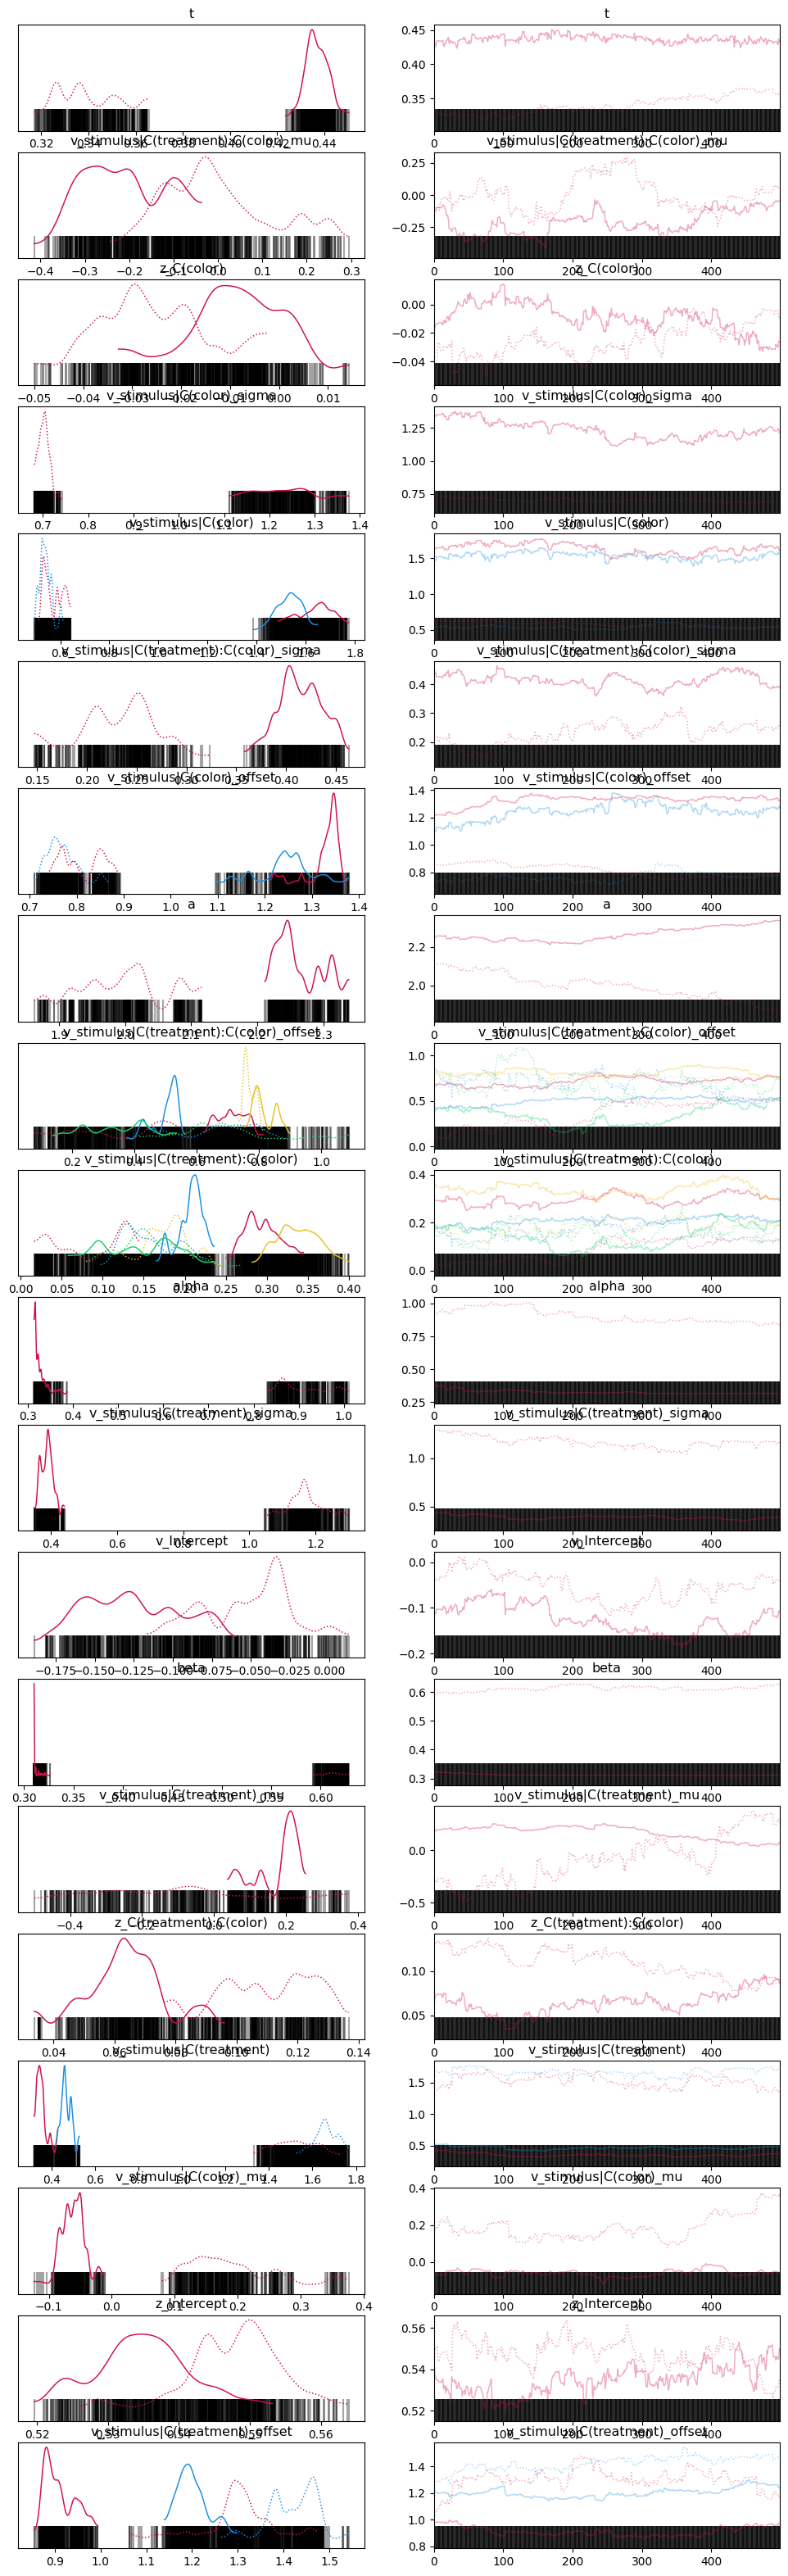

In [41]:
az.plot_trace(weibull_idata_40lapse['CG'])

### Organize Data for verification

In [ ]:


# simulated_data = get_simulated_data(model_name='weibull', model=weibull_models_40lapse)

# observed_data = weibull_models_40lapse.data.copy()
# observed_data.rename(columns={'response': 'choice', 'stimulus': 'signed_coherence'}, inplace=True)
# observed_data['signed_coherence'] = observed_data['signed_coherence'].values*100
# simulated_data['signed_coherence'] = observed_data['signed_coherence'].values
# simulated_data.rename(columns={'response': 'choice'}, inplace=True)
# simulated_data['color'] = observed_data['color'].values
# simulated_data['treatment'] = observed_data['treatment'].values
# simulated_data['subject'] = observed_data['subject'].values

In [ ]:
treatments = observed_data['treatment'].unique()
colors = observed_data['color'].unique()
colors_treatments = [(treatment, color) for treatment in treatments for color in colors]

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for idx, (treatment, color) in enumerate(colors_treatments):
        print(f"idx: {idx}, color: {color}, treatment: {treatment}")
        
        subset_idx = np.where((observed_data['treatment'] == treatment) & (observed_data['color'] == color))[0]
        # plot psychometric function
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(simulated_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='blue')
        ax[0, idx].plot(x_hat, y_hat, color='blue')
        coh, pf, pf_model, x_hat, y_hat, _ = utils.get_psychometric_data(observed_data.iloc[subset_idx])
        ax[0, idx].plot(coh, pf, 'o', color='red')
        ax[0, idx].plot(x_hat, y_hat, color='red')    
        if idx == 0:
                ax[0, idx].set_title(f"Off Medication (Equal Prior)")
        elif idx == 1:
                ax[0, idx].set_title(f"Off Medication (Positive Prior)")   
        elif idx == 2:
                ax[0, idx].set_title(f"On Medication (Equal Prior)")
        else:
                ax[0, idx].set_title(f"On Medication (Positive Prior)")
        
        
        ax[1, idx].hist(simulated_data['rt'][subset_idx], bins=25, alpha=0.5, label='simulated', color='blue')
        ax[1, idx].hist(observed_data['rt'].iloc[subset_idx], bins=25, alpha=0.5, label='observed' , color='red')
        ax[1, idx].legend()

In [10]:
prs = plot_ppt(weibull_idata_40lapse)
prs.save(Path(processed_dir, "weibull_trace.pptx"))
with open(Path(processed_dir, "weibull_idata.pickle"), "wb") as f:
    pickle.dump(weibull_idata_40lapse, f)